# Download

Instructions for how to download the data [via the PO.DAAC Data Subscriber/Downloader are avialable here](https://podaac.github.io/tutorials/quarto_text/DataSubscriberDownloader.html).

However first we need to authenticate with [Earthdata](https://urs.earthdata.nasa.gov/).

After pip install (or conda installing) earthdata in the the right environment, in python (from command line or whereever), we autheticate with the interactive approach.

- pip install earthdata
- python 
- import earthaccess
- auth = earthaccess.login(strategy = "interactive", persist = True)
- exit()

Once successful we can run the download command from the command line too. 
[Earthdata authentication instructions 1](https://podaac.github.io/tutorials/external/NASA_Earthdata_Authentication.html)
[Earthdata authentication instructions 2](https://earthaccess.readthedocs.io/en/latest/quick-start/)

We are going to use the "Downloader" which is contained in the ´podaac-data-subscriber'

- pip install podaac-data-subscriber

From terminal I used this command to download the data

`podaac-data-downloader -c TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3 -d ./data --start-date 2002-04-04T00:00:00Z --end-date 2023-04-11T00:00:00Z -b="-180,-90,180,-60`

Get more instructions with
`podaac-data-downloader -h`

# Data
 
 - **Temporal coverage**: [mid-month 2002-04 to mid-month 2024-04 (X common years)]
- **Spatial coverage**: Includes gravity over ocean. Need landmask to remove.
- **Normalisation period**: 2004.000 to 2009.999 (what is considered zero) (see "Attributes" > "time_mean_removed")
- **lwe_thickness (liquid water equivalent) units**: in cm water equivalent i.e. kg/m^2
- **Relative notion of mass balance**: Gravity is measured as reletive to a long term average. We can take difference to have monthly changes and to build a temporal model.

- https://podaac.jpl.nasa.gov/dataset/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3 

https://sealevel.nasa.gov/understanding-sea-level/key-indicators/antarctica/

In [2]:
import xarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objects as go
import pyproj

In [3]:
# File is locally on server
jplgmb = xarray.open_dataset("/home/kim/data/grace_jpl/GRCTellus.JPL.200204_202404.GLO.RL06.1M.MSCNv03CRI.nc")

# Preprocessing

- lon lat grid not polar stereo
- uncertainty is on mascon level (3 degrees?)
- resolution is essentially just 300 km (6 degrees)
- units are liquid water equivalent thickness in cm.
- equal-area 3-degree grid of individual mascons ~ 300 km
- sub-mascon resolution via gain factors 

In [4]:
jplgmb

<xarray.Dataset> Size: 1GB
Dimensions:        (lon: 720, lat: 360, time: 232, bounds: 2)
Coordinates:
  * lon            (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.8 359.2 359.8
  * lat            (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2kB 2002-04-17T12:00:00 ... 2024-04-16
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 481MB ...
    uncertainty    (time, lat, lon) float64 481MB ...
    lat_bounds     (lat, bounds) float64 6kB ...
    lon_bounds     (lon, bounds) float64 12kB ...
    time_bounds    (time, bounds) datetime64[ns] 4kB ...
    land_mask      (lat, lon) float64 2MB ...
    scale_factor   (lat, lon) float64 2MB ...
    mascon_ID      (lat, lon) float64 2MB ...
    GAD            (time, lat, lon) float64 481MB ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2024-06-27T13:06:35Z

In [5]:
# liquid water equivalent thickness in cm
jplgmb.lwe_thickness.values.shape
# half a degree: 360*720 (180*360) where 180 is north-south and 360 is east-west

(232, 360, 720)

# Try conversion to Gt

- cm w.e. to mm w.e. because this is the same as kg/m^2
- kg/m^2 to kg by multiplying by area which is 50.000 m * 50.000 m for each cell
- kg to Gt 

In [6]:
# cm to meters
cm_to_mm = 10
kg_to_gt = 1e-12

jplgmb.lwe_thickness.values * cm_to_mm * 50000*50000 * kg_to_gt

# Pass in (dims, data) tuple
jplgmb["gt"] = (jplgmb.lwe_thickness.dims, jplgmb.lwe_thickness.values * cm_to_mm * 50000*50000 * kg_to_gt)

In [7]:
# Select data under polar circle
jplgmb_gt_ant = jplgmb.gt[:, jplgmb["lat"] < -60.0, :]

# Mask out ocean
jplgmb_gt_ant.values[:, ~(jplgmb.land_mask[jplgmb["lat"] < -60.0].values.astype(bool))] = np.nan
jplgmb_gt_ant
np.nansum(jplgmb_gt_ant, axis = (1,2))

array([  237.07388246,   145.32590762,    73.96870734,   799.96613024,
         867.13738493,   359.01080445,   900.83389266,  1043.72481326,
         228.05664258,   502.36619113,  1066.12683798,  1239.83105897,
         523.23309425,   524.77512047,   310.59436651,   803.17812936,
         613.12083063,  -213.24984251,  -423.75984027, -1025.56950595,
        -330.67412745,  -664.8727463 ,   289.69917022,   305.11172249,
        -483.4251457 ,    83.33568638,   100.0761416 ,   610.84674663,
        -132.94760841,  -574.44091844,  -848.5408706 , -1115.61055402,
        -964.76271812,  -173.81202998,  -118.1674858 ,   -25.35727294,
         310.44077332,   202.53056119,   550.64995139,   673.81418852,
         848.14696753,   347.91624906,   193.56424868,  -189.25975861,
         470.00625902,   486.17504763,  1053.63284066,  1066.46551289,
         861.95716674,  1090.13317069,  1234.62255811,   991.92525501,
        1044.99385399,   307.11138356,  -555.63633496,  -245.16505506,
      

In [8]:
# Same value for 6 x 6 degree grid (300 km x 300 km)
jplgmb.lwe_thickness.values[0, 0:25, 0]
jplgmb.lwe_thickness.values[0, 30, 0:25]

array([-0.17530628, -0.17530628, -0.17530628, -0.17530628, -0.17530628,
       -0.17530628, -0.17530628, -0.17530628, -0.17530628, -0.17530628,
       -0.17530628, -0.17530628, -0.17530628, -0.17530628, -0.17530628,
       -0.17530628, -0.17530628, -0.17530628, -0.17530628, -0.17530628,
       -0.17530628, -0.17530628, -0.17530628,  0.32417455,  0.32417455])

## Only select latitudes -60 down to -90

Landmask == 1 indicates land

In [9]:
# Count cells that contain land
print(jplgmb.land_mask[jplgmb["lat"] < -60.0, :].values.sum())

# Total number of cells
jplgmb.land_mask[jplgmb["lat"] < -60.0, :].shape
# 60*720 = 43200

24308.0


(60, 720)

## Subset Antarctic data

In [10]:
# subset Antarctic data
# jplgmb.lwe_thickness[:, 0:60, :]
jplgmb_ant = jplgmb.lwe_thickness[:, jplgmb["lat"] < -60.0, :]

# Apply landmask

In [11]:
# tilde negated the land mask
# overwrite water values with NaN: Make those NaN that are not 1/True (land)
jplgmb_ant.values[:, ~(jplgmb.land_mask[jplgmb["lat"] < -60.0].values.astype(bool))] = np.nan

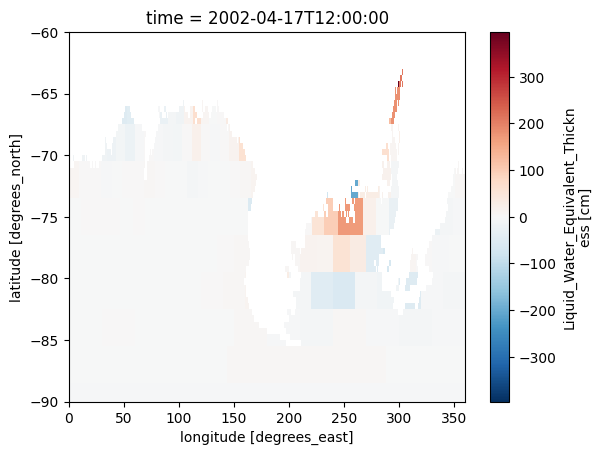

In [12]:
jplgmb_ant["time" == "2024-04-16"].plot()

## Polar Stereo Projection

We need a meshgrid because it is PROJECTION and spaces are distorted.

In [13]:
# prepare meshgrid: lonlon is xx (LHS constant), latlat is yy (RHS constant)
lonlon, latlat = np.meshgrid(jplgmb_ant.lon, jplgmb_ant.lat)

latlat
# half a degree
# 60 * 0.5 = 30 degrees

array([[-89.75, -89.75, -89.75, ..., -89.75, -89.75, -89.75],
       [-89.25, -89.25, -89.25, ..., -89.25, -89.25, -89.25],
       [-88.75, -88.75, -88.75, ..., -88.75, -88.75, -88.75],
       ...,
       [-61.25, -61.25, -61.25, ..., -61.25, -61.25, -61.25],
       [-60.75, -60.75, -60.75, ..., -60.75, -60.75, -60.75],
       [-60.25, -60.25, -60.25, ..., -60.25, -60.25, -60.25]])

In [14]:
# This is how projections work. check through tool
lonlat_to_polarstereo = pyproj.Transformer.from_crs(crs_from = pyproj.CRS("epsg:4326"),
                                                    crs_to = pyproj.CRS("epsg:3031"),
                                                    always_xy = True) # xy order convention

# Pass in lon and lat meshgrids (xx, yy) to attain x and y meshgrids
x_mesh, y_mesh = lonlat_to_polarstereo.transform(lonlon, latlat)

# This is not gridded data
# 592-355 = 237

# x_array
# 237 km spacing

## Xarray regresents gridded data which it is currently not. We can interpolate on a regular grid and then put it back into xarray.

In [17]:
import torch

In [18]:
# stack and flatten the 2D into 1D
stack = torch.stack([
    torch.tensor(x_mesh), 
    torch.tensor(y_mesh), 
    torch.tensor(np.nansum(jplgmb_ant.values, axis = (0)))
    ], dim = 0).reshape(3, -1)

stack.shape

torch.Size([3, 43200])

# Interpolation/Gaussian Smoothing with GPyTorch

In [19]:
# Same grid as for the GFZ data
# second value (end) is not included
psp_x = torch.arange(-2900000., 2900000.+1, 50000)
psp_y = torch.arange(-2400000., 2400000.+1, 50000)

psp_XX, psp_YY = np.meshgrid(psp_x, psp_y)

In [20]:
# training data 720*60 = 43200 points... too much for GP
x_train = stack[0:2, :].T
# inflated in size because 3 degree not 0.5 degree grid res.
y_train = stack[2, :].T
# y_train = stack[2, :].unsqueeze(0).T
print(x_train.shape, y_train.shape)

# 11k inference points
x_test = torch.stack((torch.tensor(psp_XX), torch.tensor(psp_YY))).reshape(2, -1).T
print(x_test.shape)

torch.Size([43200, 2]) torch.Size([43200])
torch.Size([11349, 2])


/tmp/ipykernel_233464/2644097929.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch-select_1717607455294/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  y_train = stack[2, :].T


In [21]:
import gpytorch

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

In [22]:
# Assume model is your trained GPyTorch model
for name, param in model.named_parameters():
    print(f"Parameter: {name}, Value: {param.data}")

Parameter: likelihood.noise_covar.raw_noise, Value: tensor([0.])
Parameter: covar_module.raw_outputscale, Value: 0.0
Parameter: covar_module.base_kernel.raw_lengthscale, Value: tensor([[0.]])


In [23]:
# model.eval()
# likelihood.eval()

# kernel will crash
# f_preds = model(x_test)

In [95]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html#scipy.interpolate.LinearNDInterpolator
from scipy.interpolate import LinearNDInterpolator

# pass in original values
interp = LinearNDInterpolator(list(zip(np.array(stack[0]), np.array(stack[1]))), np.array(stack[2]))
Z = interp(np.array(psp_XX), np.array(psp_YY))

In [96]:
fig = go.Figure(go.Heatmap(
    # mean or sum
    z = Z,
    colorscale = 'RdBu',
    zmid = 0,))

fig.update_layout(
    title = "Mean mass balance change over all months",
)

fig.update_traces(colorbar_orientation = "v")
fig.update_traces(colorbar_title = "mass balance [gt]")
fig.update_traces(colorbar_len = 0.7)

fig.update_layout(
    height = 800,
    width = 800,
    yaxis_scaleanchor = "x",
)

fig.update_xaxes(visible = False)
fig.update_yaxes(visible = False)

fig.update_layout(template = "plotly_white")
fig.update_layout(font_family = "Lato")
# fig.update_layout(font_family = "Open Sans")

fig.show()

The result is somewhat smoother but still quite mascony.

In [97]:
"""
ds = xarray.Dataset(
    data_vars = dict(
        cum_mass_loss = (["x", "y"], Z),
    ),
    coords = dict(
        x = ("x", psp_XX),
        y = ("y", psp_YY),
    ),
)
"""

'\nds = xarray.Dataset(\n    data_vars = dict(\n        cum_mass_loss = (["x", "y"], Z),\n    ),\n    coords = dict(\n        x = ("x", psp_XX),\n        y = ("y", psp_YY),\n    ),\n)\n'

# Not polar stereo which is a problem

In [66]:
import cartopy.crs as ccrs  # Projections list
import cartopy.feature as cfeature # for coastlines

# Platte Carre visualisation

In [75]:
lonlon, latlat = np.meshgrid(jplgmb_ant.lon, jplgmb_ant.lat)

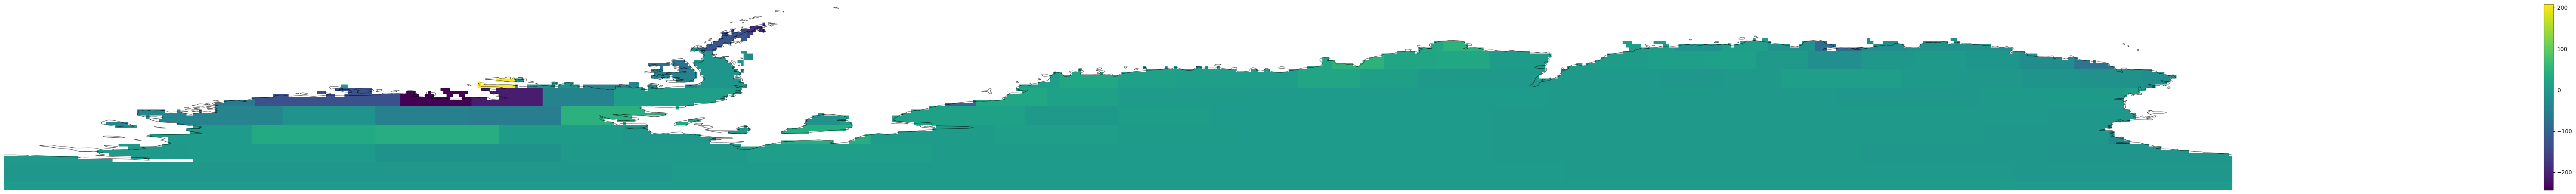

In [76]:
time = 100
base_color = "#000000"
scene_color = "#00bf9f"
hfont = {'fontname':'Helvetica'}

# Initialise plot
fig = plt.figure(figsize = [100, 6])
ax = plt.axes(projection = ccrs.PlateCarree())

# hides circular boundry line
ax.axis('off')

# restrict to lat < -65
# ax.set_extent([- 180, 180, - 90, - 65], ccrs.PlateCarree())

# thin coastline lines
ax.add_feature(cfeature.COASTLINE, edgecolor = base_color, linestyle = '-', linewidth = 0.8, alpha = 0.7)

pcm = ax.pcolormesh(lonlon, latlat, jplgmb_ant[time]) # Plot thickness data
clb = fig.colorbar(pcm, ax = ax, pad = 0.1) # Add a colorbar

plt.show()

In [84]:
cvals  = [0., 0.15, 0.3, 0.45, 0.5, 1.]
colors = ["#371229", "#B6222B", "#FF8E35", "#FCDC79", "white", "#62C3DB"]

norm = plt.Normalize(np.min(cvals), np.max(cvals))
tuples = list(zip(map(norm, cvals), colors))
nasa_cmap = mpl.colors.LinearSegmentedColormap.from_list("", tuples)

# Mean long-term field

2004-2009

In [153]:
# jplgmb_ant.time[18]
# jplgmb_ant.time[90]
jplgmb_ant[18:90]

jplgmb_ant_mean_field = np.mean(jplgmb_ant[18:90], axis = 0)

# 2002-04
jplgmb_ant_2012 = jplgmb_ant[0] - jplgmb_ant_mean_field

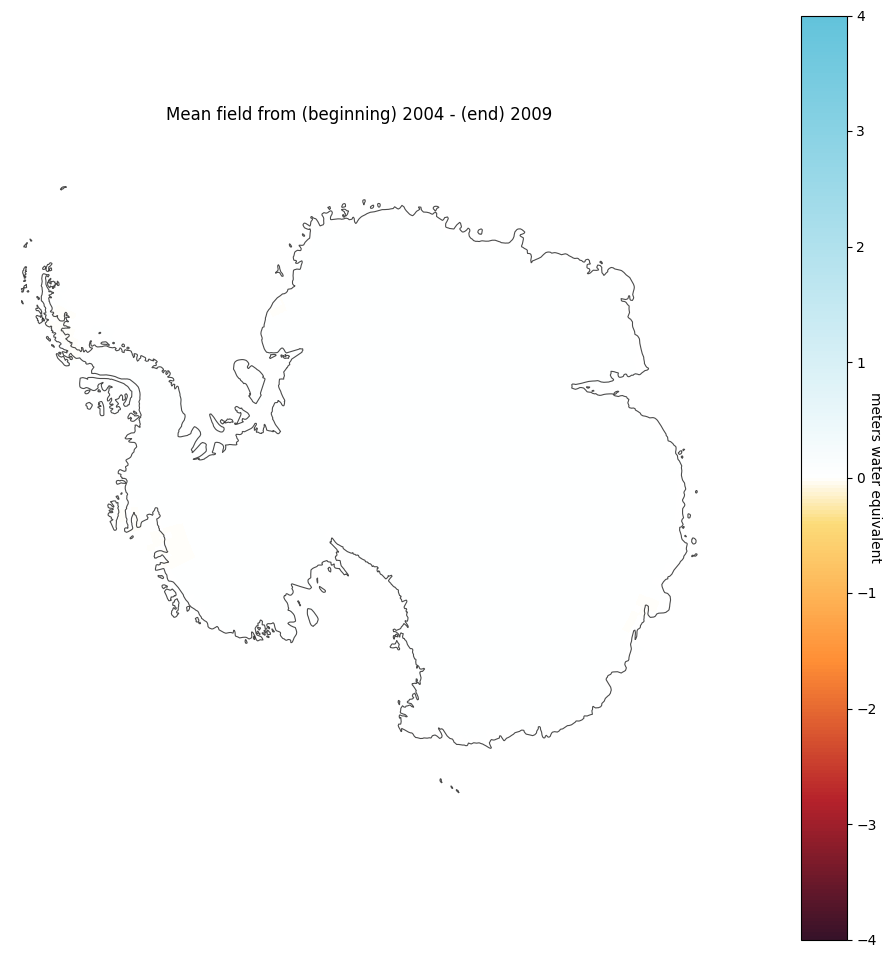

In [154]:
base_color = "#000000"
scene_color = "#00bf9f"
hfont = {'fontname':'Helvetica'}

# Initialise plot
fig = plt.figure(figsize = [12, 12])
ax = plt.axes(projection = ccrs.SouthPolarStereo())

# hides circular boundry line
ax.axis('off')

# restrict to lat < -65
ax.set_extent([- 180, 180, - 90, - 65], ccrs.PlateCarree())

# thin coastline lines
ax.add_feature(cfeature.COASTLINE, edgecolor = base_color, linestyle = '-', linewidth = 0.8, alpha = 0.7)

# * 0.01 to convert cm to m
# Hardcoded bounds to make 0 white
pcm = ax.pcolormesh(x_array, y_array, np.mean(jplgmb_ant, axis = 0) * 0.01, cmap = nasa_cmap, vmin = -4, vmax = 4)
pcm = ax.pcolormesh(x_array, y_array, np.mean(jplgmb_ant[18:90], axis = 0) * 0.01, cmap = nasa_cmap, vmin = -4, vmax = 4)
clb = fig.colorbar(pcm, ax = ax, pad = 0.1,) # Add a colorbar
clb.set_label('meters water equivalent', rotation = 270)

plt.title("Mean field from (beginning) 2004 - (end) 2009")
# cbar = colorbar.ColorbarBase(ax, cmap=plt.get_cmap('coolwarm'),
#  norm=colors.Normalize(vmin=-.5, vmax=1.5)) # set min, max of colorbar
# cbar.set_clim(-.5, .5)

plt.show()

In [164]:
jplgmb_ant[226]

<xarray.DataArray 'lwe_thickness' (lat: 60, lon: 720)> Size: 346kB
array([[14.360428, 14.360428, 14.360428, ..., 14.360428, 14.360428, 14.360428],
       [14.360428, 14.360428, 14.360428, ..., 14.360428, 14.360428, 14.360428],
       [14.360428, 14.360428, 14.360428, ..., 14.360428, 14.360428, 14.360428],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]])
Coordinates:
  * lon      (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float64 480B -89.75 -89.25 -88.75 ... -61.25 -60.75 -60.25
    time     datetime64[ns] 8B 2023-11-16
Attributes:
    units:          cm
    long_name:      Liquid_Water_Equivalent_Thickness
    standard_name:  Liquid_Water_Equivalent_Thickness
    grid_mapping:   WGS84
    valid_min:      -2073.5950112366636
    valid_max:      1027.2036093626584
    comment:        Coastline Resolution Improvement (CRI) filter is applied

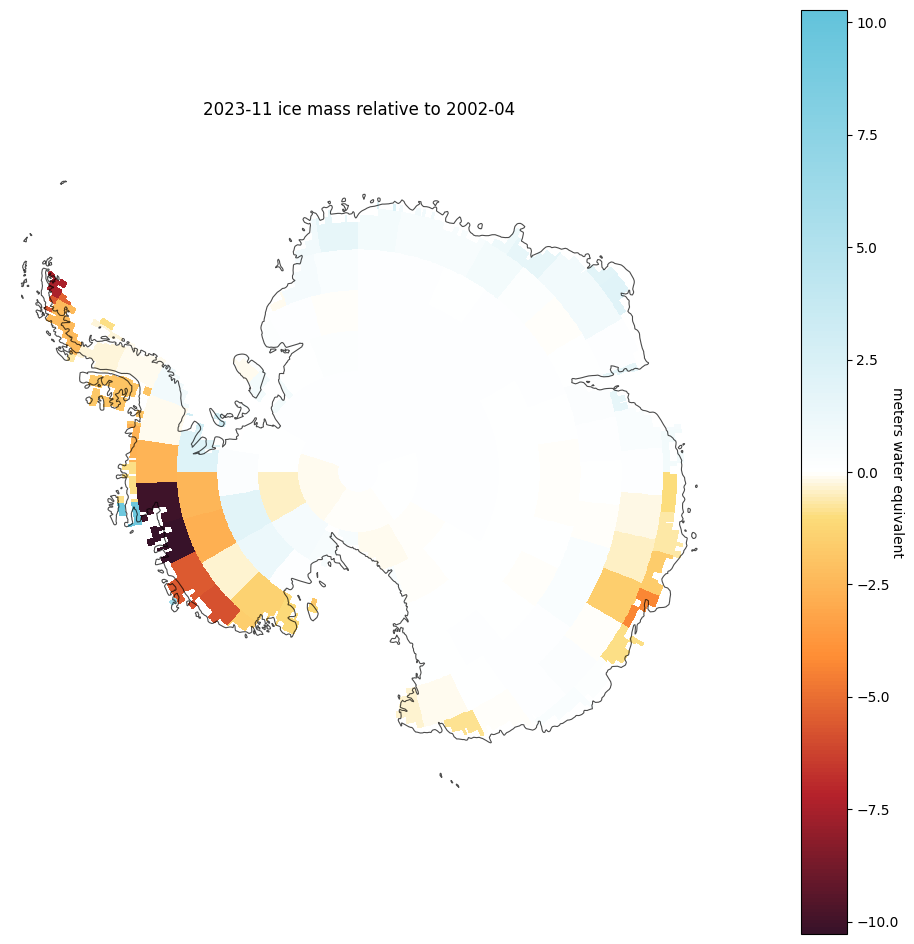

In [170]:
# time = 120
time = 226
base_color = "#000000"
scene_color = "#00bf9f"
hfont = {'fontname':'Helvetica'}

# Initialise plot
fig = plt.figure(figsize = [12, 12])
ax = plt.axes(projection = ccrs.SouthPolarStereo())

# hides circular boundry line
ax.axis('off')

# restrict to lat < -65
ax.set_extent([- 180, 180, - 90, - 65], ccrs.PlateCarree())

# thin coastline lines
ax.add_feature(cfeature.COASTLINE, edgecolor = base_color, linestyle = '-', linewidth = 0.8, alpha = 0.7)

# * 0.01 to convert cm to m
pcm = ax.pcolormesh(x_array, y_array, jplgmb_ant[time] * 0.01, cmap = nasa_cmap, 
                    vmin = np.nanmin(jplgmb_ant[time] * 0.01),  
                    # define max as negative min to keep 0 white
                    vmax = -np.nanmin(jplgmb_ant[time] * 0.01)) # Plot thickness data
clb = fig.colorbar(pcm, ax = ax, pad = 0.1,) # Add a colorbar
clb.set_label('meters water equivalent', rotation = 270)

plt.title("2023-11 ice mass relative to 2002-04")

plt.show()

# Make relative to 2012

- subract mean field
- subtract 2012 relative to mean field

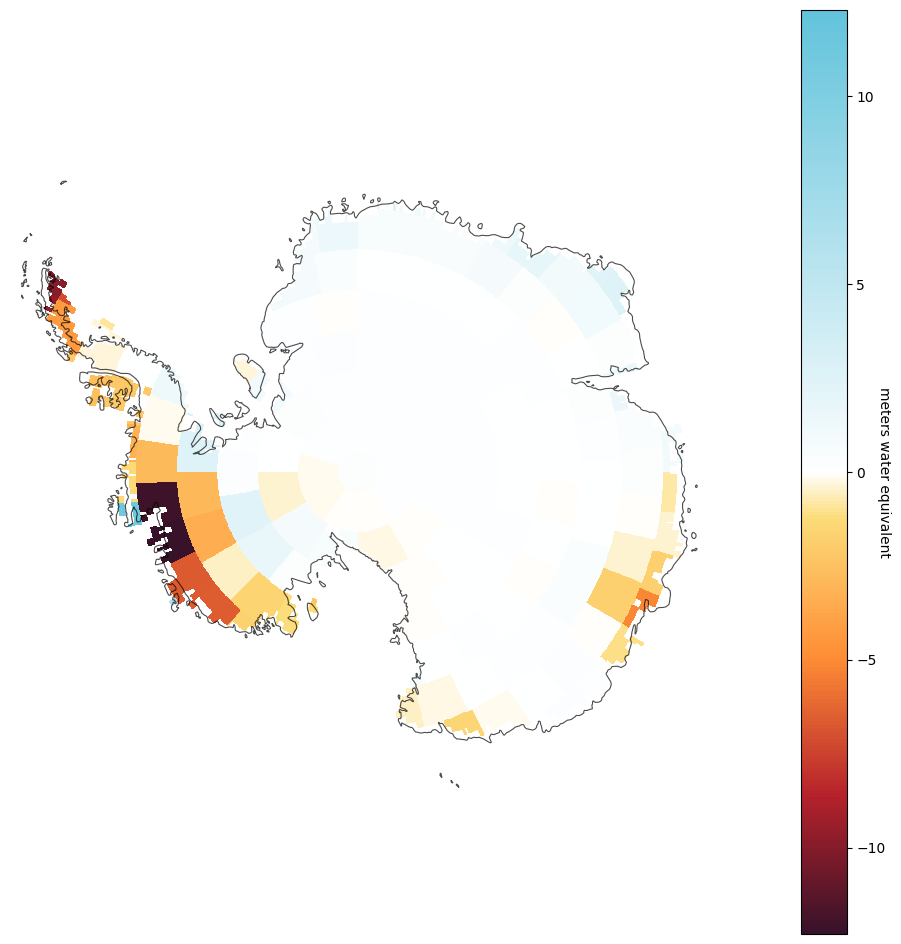

In [161]:
time = 230
base_color = "#000000"
scene_color = "#00bf9f"
hfont = {'fontname':'Helvetica'}

# Initialise plot
fig = plt.figure(figsize = [12, 12])
ax = plt.axes(projection = ccrs.SouthPolarStereo())

# hides circular boundry line
ax.axis('off')

# restrict to lat < -65
ax.set_extent([- 180, 180, - 90, - 65], ccrs.PlateCarree())

# thin coastline lines
ax.add_feature(cfeature.COASTLINE, edgecolor = base_color, linestyle = '-', linewidth = 0.8, alpha = 0.7)

# * 0.01 to convert cm to m
pcm = ax.pcolormesh(x_array, y_array, ((jplgmb_ant[time] - jplgmb_ant_mean_field - 
jplgmb_ant_2012) * 0.01), cmap = nasa_cmap, 
                    vmin = np.nanmin((jplgmb_ant[time] - jplgmb_ant_mean_field - 
jplgmb_ant_2012) * 0.01),  
                    # define max as negative min to keep 0 white
                    vmax = -np.nanmin((jplgmb_ant[time] - jplgmb_ant_mean_field - 
jplgmb_ant_2012) * 0.01)) # Plot thickness data
clb = fig.colorbar(pcm, ax = ax, pad = 0.1,) # Add a colorbar
clb.set_label('meters water equivalent', rotation = 270)


# cbar = colorbar.ColorbarBase(ax, cmap=plt.get_cmap('coolwarm'),
#  norm=colors.Normalize(vmin=-.5, vmax=1.5)) # set min, max of colorbar
# cbar.set_clim(-.5, .5)

plt.show()

# Interpolate to polar stereo grid